In [20]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import scipy
import tensorflow as tf
from sopt.examples.utils import PtychographySimulation
from sopt.examples.tensorflow.far_field_ptychography.tfPtycho import AdamPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

In [2]:
%load_ext autoreload
%autoreload 2

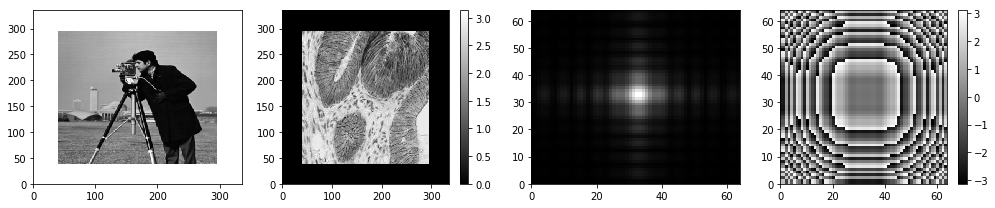

In [8]:
ptsim = PtychographySimulation( positions_step_npix=6)

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax1, ax=axs[1])
plt.colorbar(cax3, ax=axs[3])
plt.tight_layout()
plt.show()

## Adam - reconstructing the object only

In [34]:
pr_adam = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=50)
pr_adam.setOptimizingParams(learning_rate_obj=1.0)
pr_adam.initSession()

In [35]:
adam_errors = np.array([])
adam_losses = np.array([])
validation_losses = np.array([])
validation_best_loss = np.inf
validation_frequency = 1 #epochs
improvement_threshold = 1e-3
patience = 50 # epochs
patience_increase = 2 # epochs
epoch = 0
for i in tqdm(range(10000)):
    lossval, _ = pr_adam.session.run([pr_adam.training_loss_tensor, pr_adam.obj_minimize_op])
    adam_losses = np.append(adam_losses, lossval)
    
    if i % (ptsim._ndiffs // pr_adam._batch_size) != 0: 
        continue
    
    epoch += 1
    #if epoch >= patience:
    #    break
    if epoch >= patience:
        break
    
    if epoch % validation_frequency != 0:
        continue
    
    recons_obj_padded = pr_adam.session.run(pr_adam._tf_obj_padded_cmplx)
    recons_obj = recons_obj_padded[40:-40, 40:-40]
    shift, err, phase = register_translation(recons_obj, ptsim._obj_true, upsample_factor=10)
    shift, err, phase = register_translation(recons_obj * np.exp(-1j * phase), ptsim._obj_true, upsample_factor=10)
    adam_errors = np.append(adam_errors, err)
    
    validation_loss = pr_adam.session.run(pr_adam.validation_loss_tensor)
    #validation_loss = genValidation(recons_obj_padded)
    validation_losses = np.append(validation_losses, validation_loss)
    
    #validation_loss = lossval
    if validation_loss < validation_best_loss:
    
        if np.abs(validation_loss - validation_best_loss) > validation_best_loss * improvement_threshold:
            patience = max(patience, epoch * patience_increase)
            
        validation_best_loss = validation_loss
        
    if epoch % 10 == 0:
        print(f'{epoch} {lossval:8.7g}, {err:8.7g}, {patience:8.7g}, {validation_loss:8.7g}, {validation_best_loss:8.7g}') 

10 1.897764e+08, 0.6891924,       50,  3526450,  1440837
20 4.200144e+07, 0.5172532,       50,  1037497, 900142.2
30 1.466201e+07, 0.3675858,       60, 363083.9, 363083.9
40  6699014, 0.2524842,       80, 164324.2, 164324.2
50  3233770, 0.1626187,      100, 82154.06, 82154.06
60  1955546, 0.1072558,      120, 50067.82, 50067.82
70  1483538, 0.07205136,      140,  37205.7,  37205.7
80  1309236, 0.0499052,      160, 32599.34, 32599.34
90  1245623, 0.03481607,      180, 30913.11, 30913.11
100  1222289, 0.02562504,      200, 30255.81, 30255.81
110  1213820, 0.02077456,      202, 30014.12, 30014.12
120  1210751, 0.01845743,      202, 29931.16, 29931.16
130  1209653, 0.01750185,      202, 29905.32, 29905.32
140  1209268, 0.01723658,      202, 29894.96, 29894.96
150  1209131, 0.01717456,      202, 29889.47, 29889.47
160  1209083, 0.01715887,      202, 29887.08, 29887.08
170  1209066, 0.01715799,      202, 29888.88, 29887.07
180  1209060, 0.01715664,      202, 29888.26, 29887.07
190  1209058, 

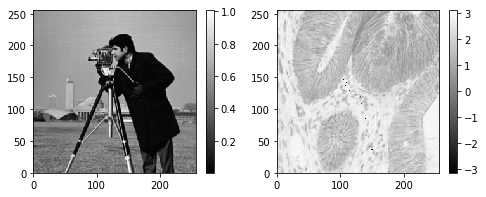

In [14]:
recons_obj = pr_adam.session.run(pr_adam._tf_obj_padded_cmplx)[40:-40, 40:-40]
plt.figure(figsize=[8,3])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons_obj), cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons_obj), cmap='gray')
plt.colorbar()
plt.show()

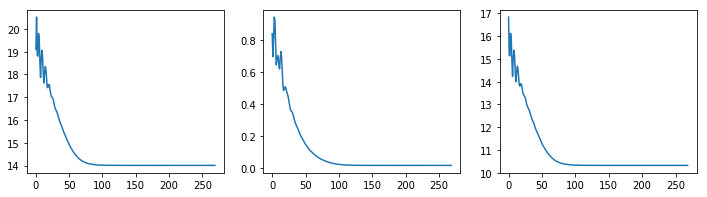

In [16]:
fig, axs = plt.subplots(1,3,figsize=[12,3])
axs[0].plot(np.log(adam_losses))
axs[1].plot(adam_errors)
axs[2].plot(np.log(validation_losses))
plt.show()

In [17]:
with pr_adam.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_adam = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_adam = flops_adam.total_float_ops
    print(flops_adam)

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
2715585693


In [24]:
graph_def = pr_adam.graph.as_graph_def()
# To calculate the flops required for one adam step,
# I am removing the nodes required for the validation step.
nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_adam.graph, nodes_validation)
flops_validation

22777709

In [40]:
total_flops = (flops_adam * i - flops_validation * epoch)
print(f'total flops {total_flops:4.3g}')

total flops 9.43e+11


## Adam minibatch 200

In [36]:
pr_adam = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, batch_size=200, validation_ndiffs=50)
pr_adam.setOptimizingParams(learning_rate_obj=0.01)
pr_adam.initSession()

In [37]:
adam_errors = np.array([])
adam_losses = np.array([])
validation_losses = np.array([])
validation_best_loss = np.inf
validation_frequency = 1 #epochs
improvement_threshold = 1e-3
patience = 50 # epochs
patience_increase = 2 # epochs
epoch = 0
for i in tqdm(range(10000)):
    lossval, _ = pr_adam.session.run([pr_adam.training_loss_tensor, pr_adam.obj_minimize_op])
    _ = pr_adam.session.run(pr_adam._assign_op)
    adam_losses = np.append(adam_losses, lossval)
    
    if i % (ptsim._ndiffs // pr_adam._batch_size) != 0: 
        continue
    
    epoch += 1
    if epoch >= patience:
        break
    #if i >= patience:
    #    break
    
    if epoch % validation_frequency != 0:
        continue
    
    recons_obj_padded = pr_adam.session.run(pr_adam._tf_obj_padded_cmplx)
    recons_obj = recons_obj_padded[40:-40, 40:-40]
    shift, err, phase = register_translation(recons_obj, ptsim._obj_true, upsample_factor=10)
    shift, err, phase = register_translation(recons_obj * np.exp(-1j * phase), ptsim._obj_true, upsample_factor=10)
    adam_errors = np.append(adam_errors, err)
    
    validation_loss = pr_adam.session.run(pr_adam.validation_loss_tensor)
    validation_losses = np.append(validation_losses, validation_loss)
    #validation_loss = lossval
    if validation_loss < validation_best_loss:
        
        if np.abs(validation_loss - validation_best_loss) > validation_best_loss * improvement_threshold:
            patience = max(patience, epoch * patience_increase)
            
        validation_best_loss = validation_loss
        
    if epoch % 10 == 0: 
        print(f'{epoch} {lossval:8.7g}, {err:8.7g}, {patience:8.7g}, {validation_loss:8.7g}, {validation_best_loss:8.7g}') 

10  2341476, 0.5714615,       50, 568776.9, 568776.9
20 533888.1, 0.3968407,       50, 141022.9, 141022.9
30   239055, 0.3189654,       60, 62768.59, 62768.59
40 161030.7, 0.2749073,       80, 44172.26, 44172.26
50 139916.6, 0.2443211,      100, 37959.83, 37959.83
60 132716.9, 0.2210221,      120, 34848.18, 34848.18
70 127019.3, 0.2023273,      140, 33197.01, 33197.01
80 126066.8, 0.1864027,      160,  32183.2,  32183.2
90 122260.8, 0.1722472,      178, 31588.26, 31588.26
100 123132.7, 0.1592395,      200, 31159.56, 31159.56
110 120936.4, 0.1470377,      212, 30953.76, 30952.78
120 120080.3, 0.1353993,      238, 30706.25, 30706.25
130 120282.7, 0.1243404,      256, 30548.64, 30548.64
140 120875.9, 0.1139105,      256, 30512.76, 30503.98
150   117152, 0.1038825,      286, 30378.96, 30378.96
160   121738, 0.09446305,      286, 30312.99, 30305.25
170   120115, 0.08568056,      286, 30338.35, 30278.73
180 119413.6, 0.07741067,      286, 30230.98, 30230.98
190 119659.7, 0.06959157,      372

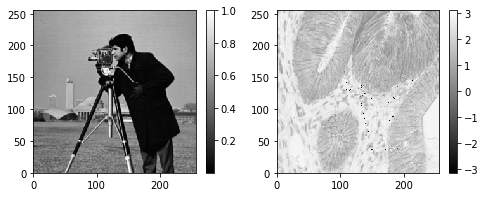

In [38]:
recons_obj = pr_adam.session.run(pr_adam._tf_obj_padded_cmplx)[40:-40, 40:-40]
plt.figure(figsize=[8,3])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons_obj), cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons_obj), cmap='gray')
plt.colorbar()
plt.show()

In [41]:
with pr_adam.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_adam = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_adam = flops_adam.total_float_ops
    print(flops_adam)

256506583


In [43]:
graph_def = pr_adam.graph.as_graph_def()
# To calculate the flops required for one adam step,
# I am removing the nodes required for the validation step.
nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_adam.graph, nodes_validation)
flops_validation

22777709

In [44]:
total_flops = flops_adam * i - flops_validation * epoch
print(f'total flops {total_flops:4.3g}')

total flops 9.43e+11
